# Notebook 06: Cell Type Annotation

**Objective**: Assign biological cell type labels to clusters based on marker genes.

## What you will learn:
- Manual annotation using marker genes
- Remove technical artifacts (platelets, stressed cells)
- Merge similar clusters (optional)
- Validate annotations
- Visualize annotated cell types

## From Numbers to Biology

Right now, clusters are just numbers (0, 1, 2, ...). We need to give them **biological meaning**!

**Cluster 0** → **CD4+ T cells**  
**Cluster 2** → **B cells**  
**Cluster 3** → **CD14+ Monocytes**

## Annotation Strategy

Based on Notebook 05 marker genes, we identified:

| Cluster | Cell Type | Key Markers |
|---------|-----------|-------------|
| 0 | CD4+ T cells | IL7R, CD3D, LTB |
| 1 | Ribosomal/Stressed | RPL32, RPS27 (artifact) |
| 2 | B cells | CD79A, CD79B |
| 3 | CD14+ Monocytes | S100A8, S100A9, LYZ |
| 4 | CD16+ Monocytes | CST3, HLA-DRB1 |
| 5 | CD8+ T cells (Memory) | CCL5, GZMK |
| 6 | NK cells | GNLY, GZMB, PRF1 |
| 7 | CD8+ T cells (Cytotoxic) | CCL5, NKG7, CST7 |
| 8 | CD16+ Monocytes | FCGR3A, LST1 |
| 9 | Platelets | PF4, PPBP (contaminant) |

## Workflow:
1. Load data with marker genes
2. Manually annotate clusters
3. Remove artifacts (platelets, stressed cells)
4. Optionally merge similar clusters
5. Visualize annotated UMAP
6. Analyze cell type proportions
7. Validate annotations
8. Save final annotated data

In [2]:
# Import libraries
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure Scanpy
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Paths
data_dir = '../data/'
results_dir = '../results/'

print("Libraries imported successfully!")
print(f"Scanpy version: {sc.__version__}")

Libraries imported successfully!
Scanpy version: 1.11.4


## 1. Load Data

Load the data from Notebook 05 with marker gene results.

In [4]:
# Load data with markers
adata = sc.read_h5ad(f'{data_dir}pbmc3k_markers.h5ad')

print("=" * 60)
print("LOADED DATA")
print("=" * 60)
print(adata)
print(f"Dimensions: {adata.shape[0]} cells × {adata.shape[1]} genes")
print(f"Number of clusters: {adata.obs['leiden'].nunique()}")
print(f"\nCluster sizes:")
print(adata.obs['leiden'].value_counts().sort_index())

LOADED DATA
AnnData object with n_obs × n_vars = 2689 × 13671
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden_1.0', 'leiden_0.4', 'leiden_0.8', 'leiden_1.5', 'leiden_2.0', 'leiden'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'dendrogram_leiden', 'hvg', 'leiden_0.4', 'leiden_0.4_colors', 'leiden_0.8', 'leiden_0.8_colors', 'leiden_1.0', 'leiden_1.0_colors', 'leiden_1.5', 'leiden_1.5_colors', 'leiden_2.0', 'leiden_2.0_colors', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
Dimensions: 2689 cells × 13671 genes
Number of clusters: 10

Cluster sizes:
leiden
0    569
1    540
2    348
3    300
4    239
5    221
6    159
7    152
8    146
9     15
Name: count, dtype: int6

## 2. Manual Annotation

Based on marker genes from Notebook 05, we assign cell type labels to each cluster.

In [5]:
# Create annotation dictionary
cluster_annotations = {
    '0': 'CD4+ T cells',
    '1': 'Stressed cells',  # Will be removed
    '2': 'B cells',
    '3': 'CD14+ Monocytes',
    '4': 'CD16+ Monocytes',
    '5': 'CD8+ T cells',
    '6': 'NK cells',
    '7': 'CD8+ T cells',  # Similar to cluster 5
    '8': 'CD16+ Monocytes',  # Similar to cluster 4
    '9': 'Platelets'  # Will be removed
}

# Add cell type annotation
adata.obs['cell_type'] = adata.obs['leiden'].map(cluster_annotations)

print("=" * 60)
print("CELL TYPE ANNOTATIONS")
print("=" * 60)
for cluster, cell_type in cluster_annotations.items():
    n_cells = (adata.obs['leiden'] == cluster).sum()
    print(f"Cluster {cluster}: {cell_type:25s} ({n_cells:4d} cells)")

CELL TYPE ANNOTATIONS
Cluster 0: CD4+ T cells              ( 569 cells)
Cluster 1: Stressed cells            ( 540 cells)
Cluster 2: B cells                   ( 348 cells)
Cluster 3: CD14+ Monocytes           ( 300 cells)
Cluster 4: CD16+ Monocytes           ( 239 cells)
Cluster 5: CD8+ T cells              ( 221 cells)
Cluster 6: NK cells                  ( 159 cells)
Cluster 7: CD8+ T cells              ( 152 cells)
Cluster 8: CD16+ Monocytes           ( 146 cells)
Cluster 9: Platelets                 (  15 cells)


## 3. Visualize Annotated UMAP

Let's see how the annotated cell types look on UMAP.

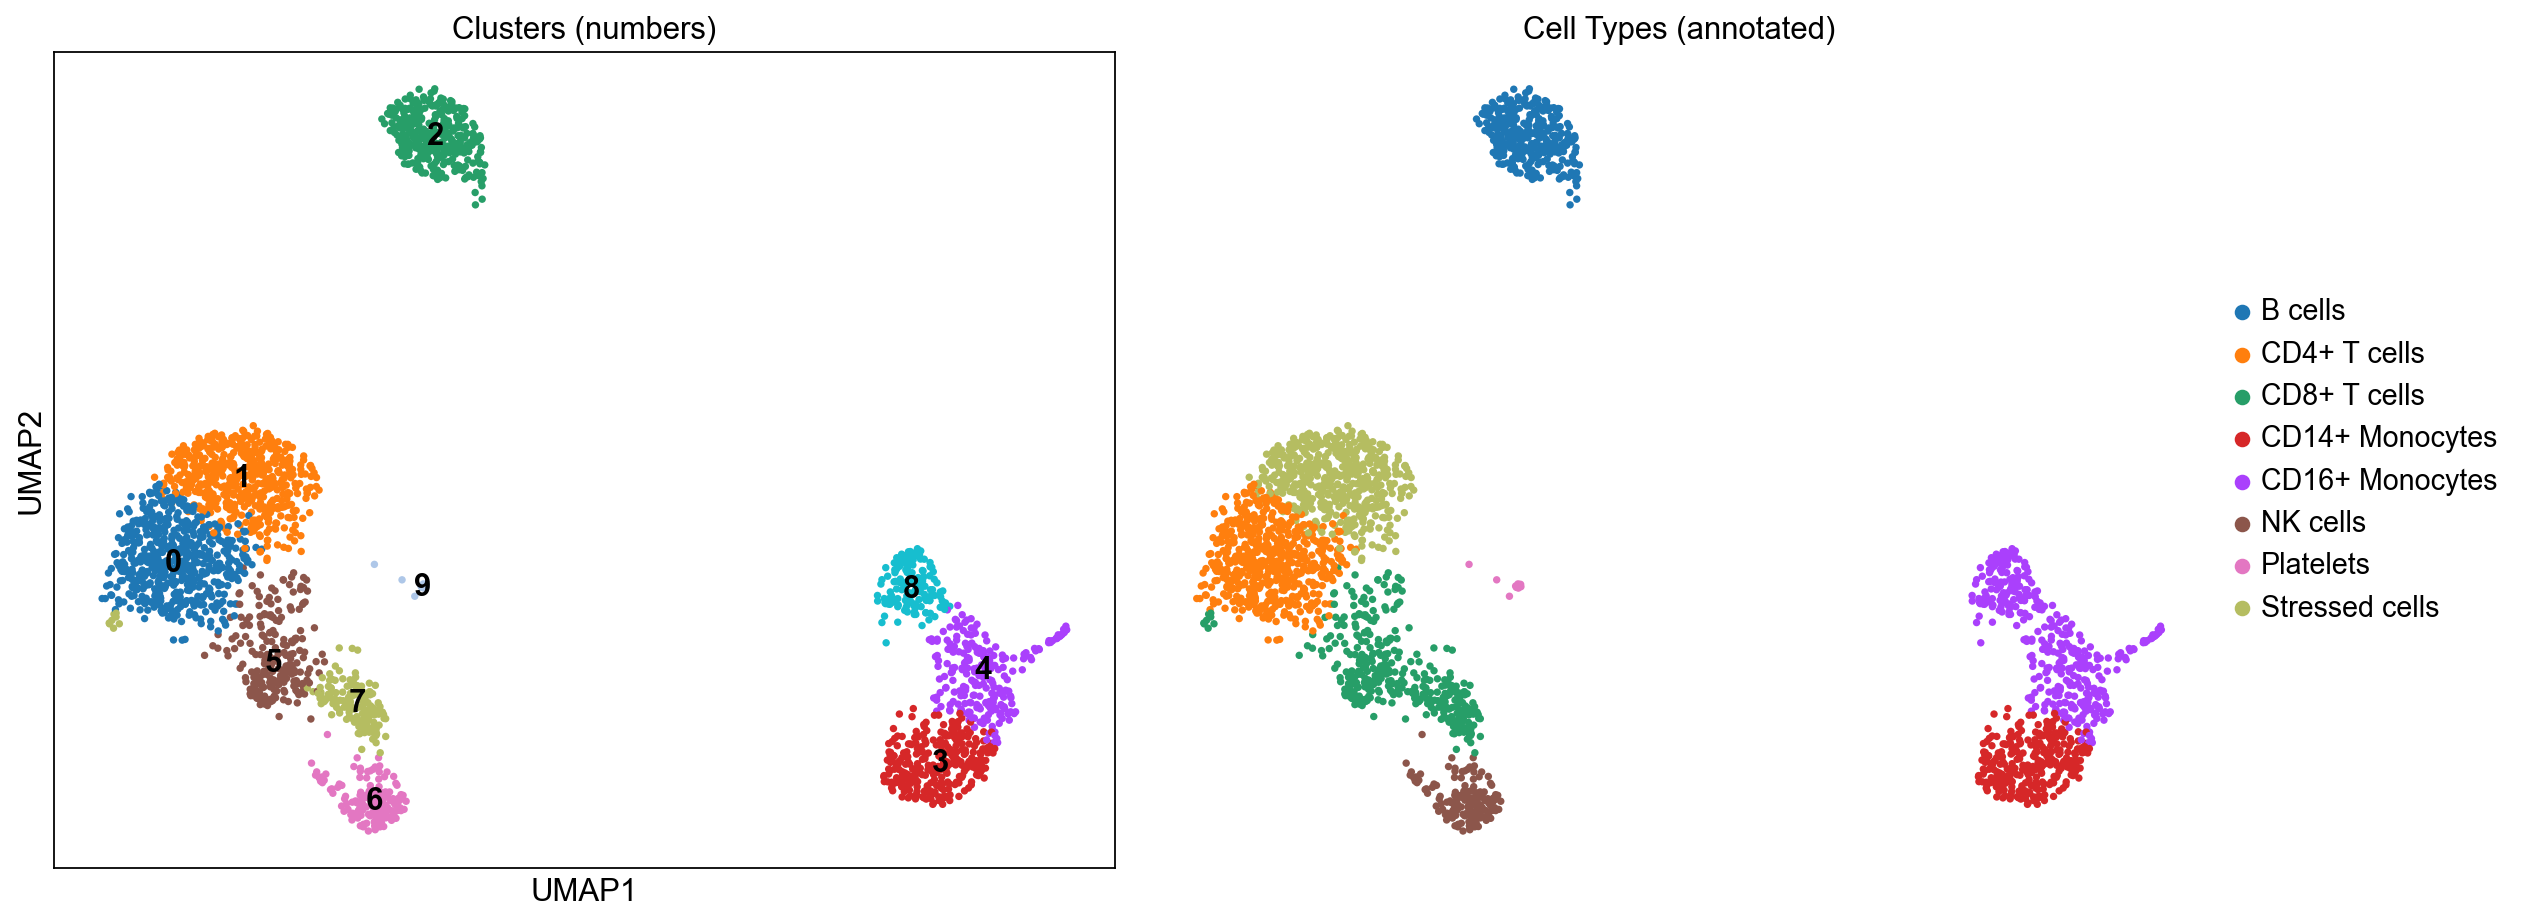

Annotated UMAP created


In [7]:
# Visualize annotated UMAP
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# By cluster number
sc.pl.umap(adata, color='leiden', legend_loc='on data', ax=axes[0], show=False, title='Clusters (numbers)')

# By cell type
sc.pl.umap(adata, color='cell_type', ax=axes[1], show=False, title='Cell Types (annotated)', frameon=False)

plt.tight_layout()
plt.savefig(f'{results_dir}06_umap_annotated.png', dpi=150, bbox_inches='tight')
plt.show()

print("Annotated UMAP created")

## 4. Remove Artifacts

Remove technical artifacts:
- **Cluster 9**: Platelets (not nucleated cells)
- **Cluster 1**: Stressed/ribosomal cells (technical artifact)

In [9]:
# Identify cells to remove
cells_to_remove = adata.obs['leiden'].isin(['1', '9'])

print("=" * 60)
print("REMOVING ARTIFACTS")
print("=" * 60)
print(f"Cluster 1 (Stressed): {(adata.obs['leiden'] == '1').sum()} cells")
print(f"Cluster 9 (Platelets): {(adata.obs['leiden'] == '9').sum()} cells")
print(f"Total to remove: {cells_to_remove.sum()} cells")
print(f"Remaining: {(~cells_to_remove).sum()} cells")

# Remove artifacts
adata_clean = adata[~cells_to_remove, :].copy()

print(f"\nArtifacts removed!")
print(f"New dimensions: {adata_clean.shape[0]} cells × {adata_clean.shape[1]} genes")

REMOVING ARTIFACTS
Cluster 1 (Stressed): 540 cells
Cluster 9 (Platelets): 15 cells
Total to remove: 555 cells
Remaining: 2134 cells

Artifacts removed!
New dimensions: 2134 cells × 13671 genes


## 5. Merge Similar Clusters (Optional)

We have duplicate cell types:
- **Clusters 5 & 7**: Both CD8+ T cells
- **Clusters 4 & 8**: Both CD16+ Monocytes

Let's merge them for cleaner annotation.

In [11]:
# Create merged cell type labels
def merge_cell_types(cell_type):
    """Merge similar cell types"""
    # All CD8+ T cells → CD8+ T cells
    if 'CD8+ T cells' in cell_type:
        return 'CD8+ T cells'
    # All CD16+ Monocytes → CD16+ Monocytes
    elif 'CD16+ Monocytes' in cell_type:
        return 'CD16+ Monocytes'
    else:
        return cell_type

# Apply merging
adata_clean.obs['cell_type_merged'] = adata_clean.obs['cell_type'].apply(merge_cell_types)

print("=" * 60)
print("MERGED CELL TYPES")
print("=" * 60)
print(adata_clean.obs['cell_type_merged'].value_counts().sort_index())

MERGED CELL TYPES
cell_type_merged
B cells            348
CD4+ T cells       569
CD8+ T cells       373
CD14+ Monocytes    300
CD16+ Monocytes    385
NK cells           159
Name: count, dtype: int64


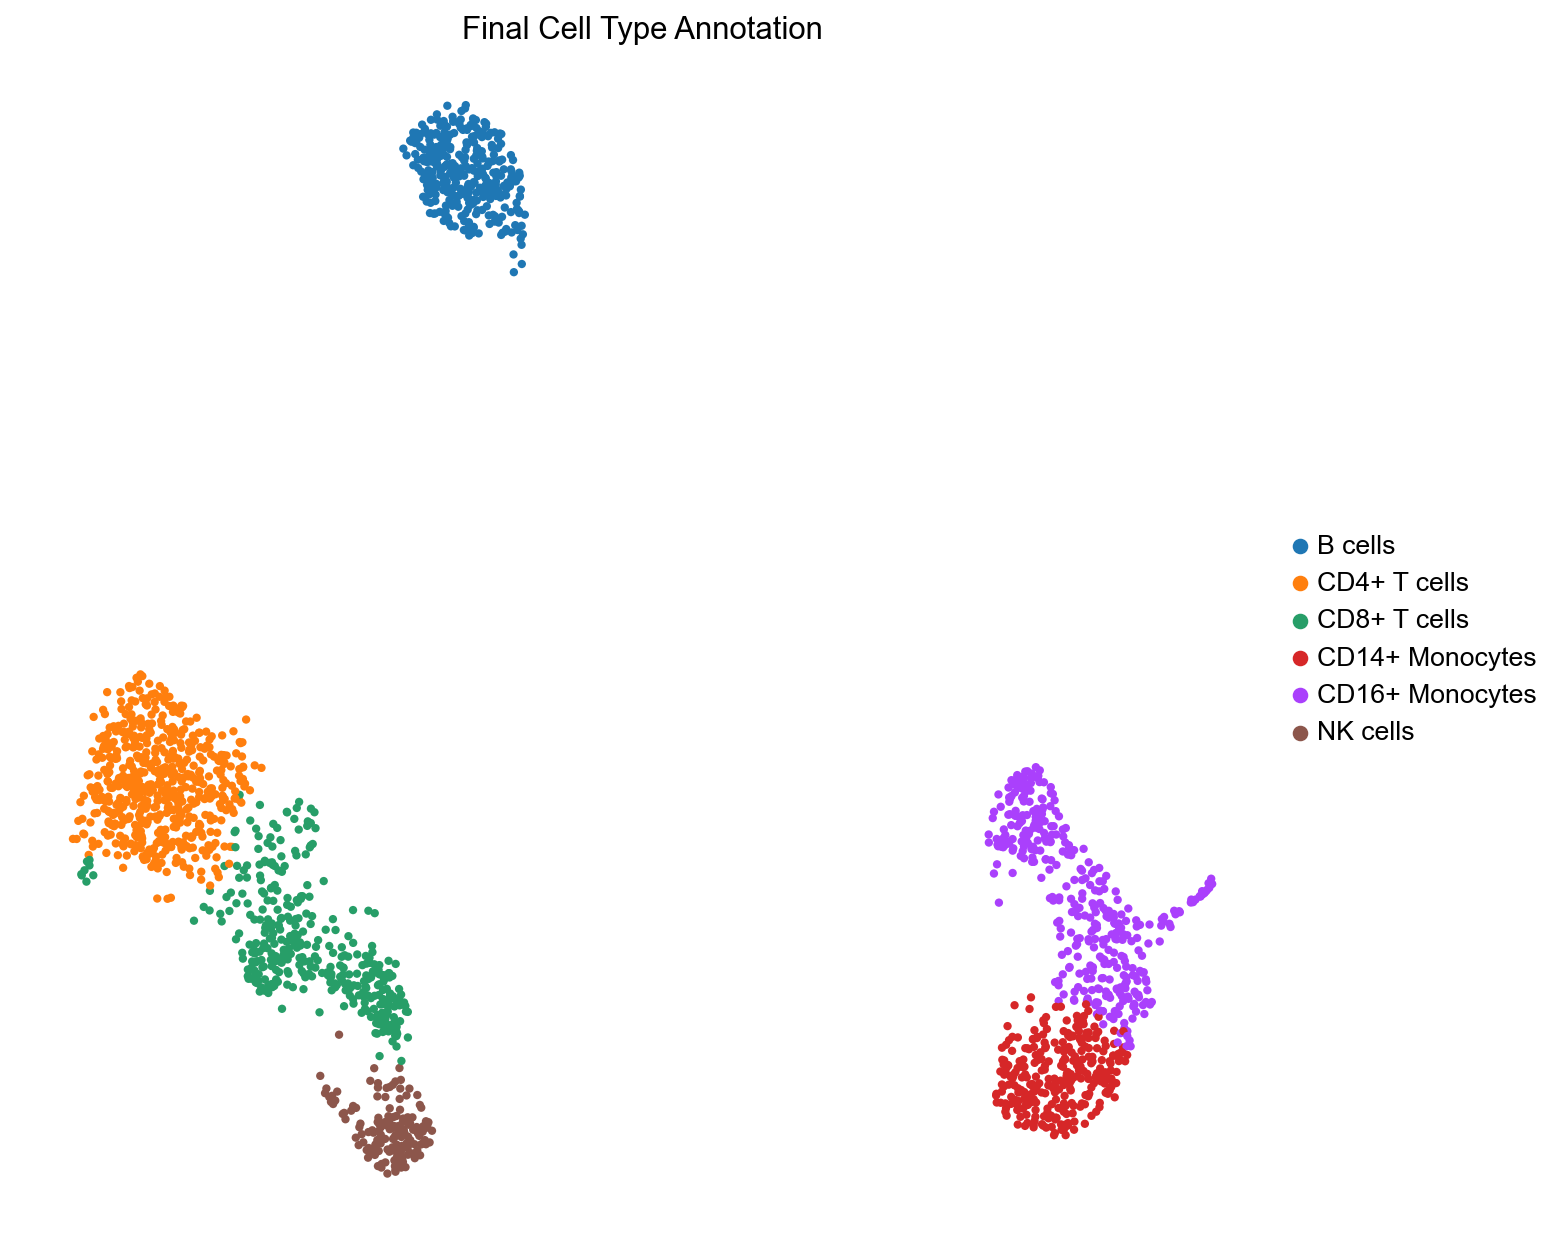

Final annotated UMAP created


In [13]:
# Visualize merged cell types
fig, ax = plt.subplots(figsize=(10, 8))

sc.pl.umap(
    adata_clean,
    color='cell_type_merged',
    ax=ax,
    show=False,
    title='Final Cell Type Annotation',
    frameon=False,
    legend_fontsize=12,
    legend_loc='right margin'
)

plt.tight_layout()
plt.savefig(f'{results_dir}06_umap_final_annotation.png', dpi=150, bbox_inches='tight')
plt.show()

print("Final annotated UMAP created")

## 6. Cell Type Proportions

Analyze the composition of our PBMC sample.

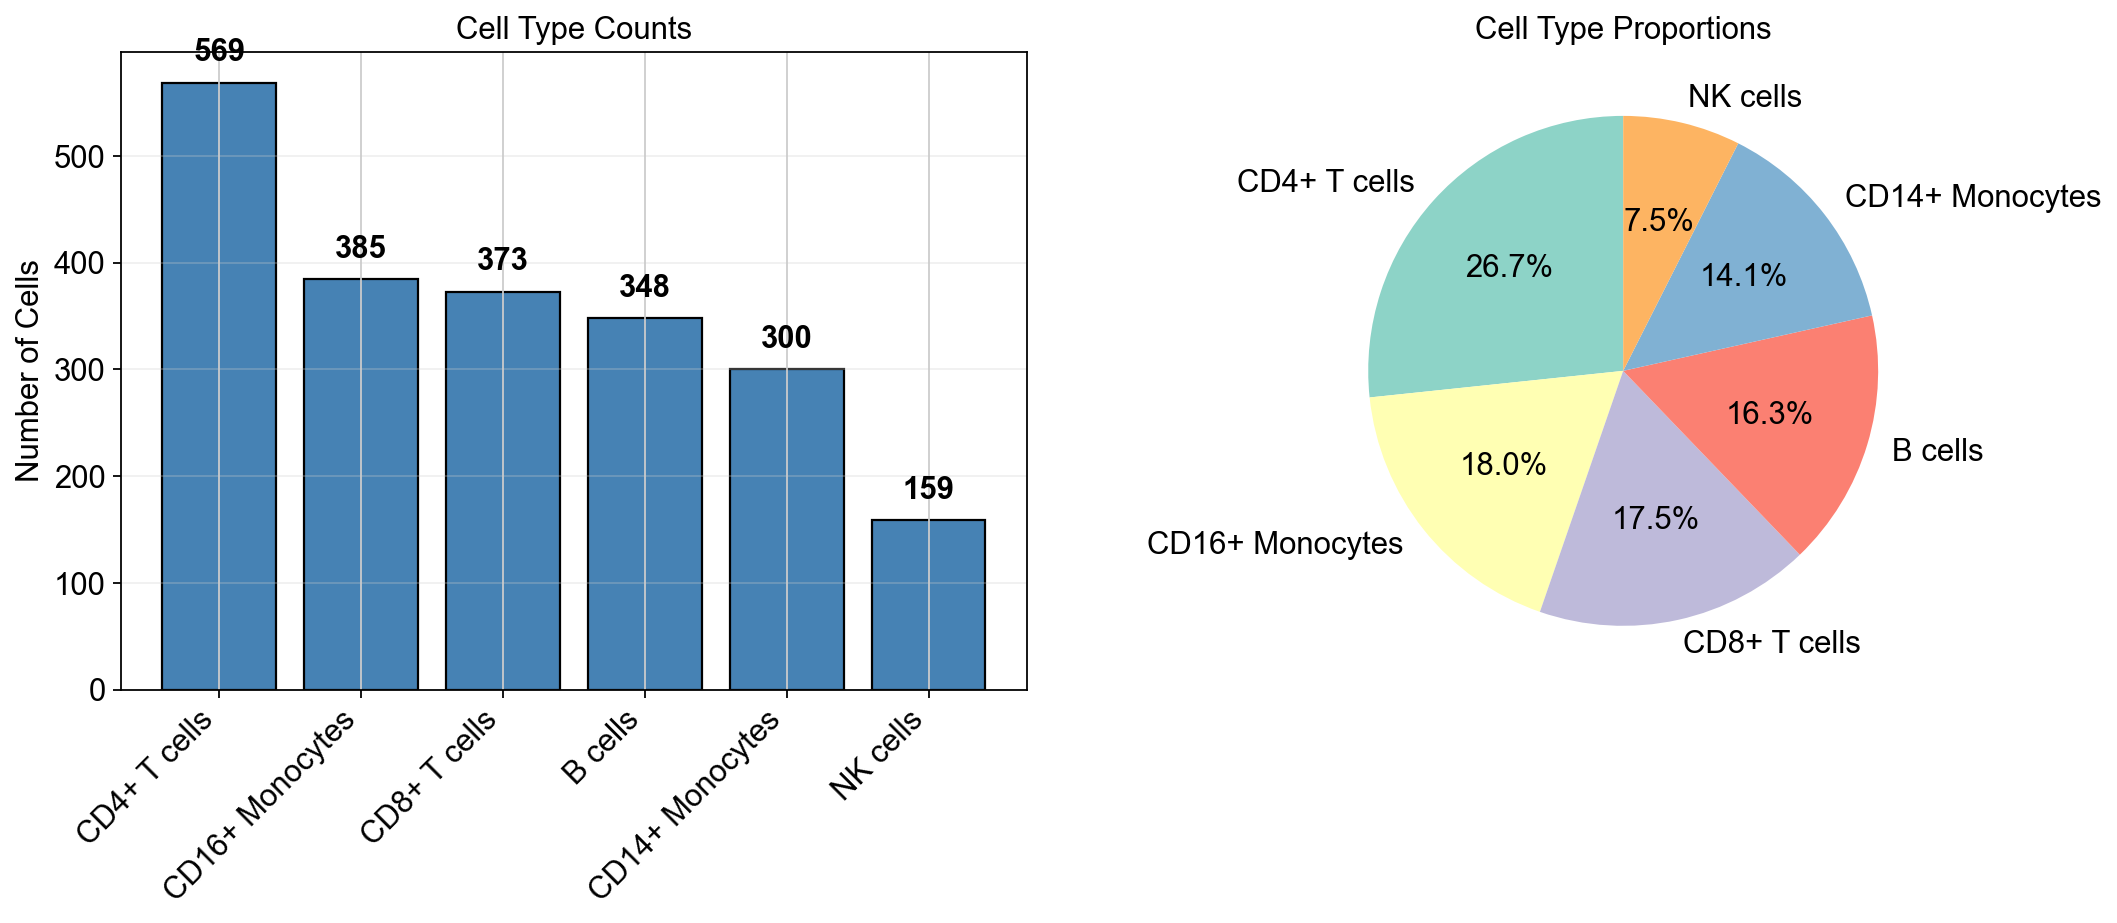

CELL TYPE COMPOSITION
CD4+ T cells             :  569 cells ( 26.7%)
CD16+ Monocytes          :  385 cells ( 18.0%)
CD8+ T cells             :  373 cells ( 17.5%)
B cells                  :  348 cells ( 16.3%)
CD14+ Monocytes          :  300 cells ( 14.1%)
NK cells                 :  159 cells (  7.5%)


In [14]:
# Calculate proportions
cell_counts = adata_clean.obs['cell_type_merged'].value_counts()
cell_proportions = (cell_counts / cell_counts.sum() * 100).round(1)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot
axes[0].bar(range(len(cell_counts)), cell_counts.values, color='steelblue', edgecolor='black')
axes[0].set_xticks(range(len(cell_counts)))
axes[0].set_xticklabels(cell_counts.index, rotation=45, ha='right')
axes[0].set_ylabel('Number of Cells')
axes[0].set_title('Cell Type Counts')
axes[0].grid(axis='y', alpha=0.3)

# Add count labels
for i, v in enumerate(cell_counts.values):
    axes[0].text(i, v + 20, str(v), ha='center', fontweight='bold')

# Pie chart
colors = plt.cm.Set3(range(len(cell_counts)))
axes[1].pie(
    cell_counts.values,
    labels=cell_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
axes[1].set_title('Cell Type Proportions')

plt.tight_layout()
plt.savefig(f'{results_dir}06_cell_type_proportions.png', dpi=150, bbox_inches='tight')
plt.show()

print("=" * 60)
print("CELL TYPE COMPOSITION")
print("=" * 60)
for cell_type, count in cell_counts.items():
    prop = cell_proportions[cell_type]
    print(f"{cell_type:25s}: {count:4d} cells ({prop:5.1f}%)")

## 7. Validate Annotations

Check that known markers are expressed in the correct cell types.

In [15]:
# Known markers for validation
validation_markers = {
    'T cells': ['CD3D', 'CD3E'],
    'CD4+ T cells': ['CD4', 'IL7R'],
    'CD8+ T cells': ['CD8A', 'CD8B'],
    'B cells': ['CD79A', 'MS4A1'],
    'NK cells': ['GNLY', 'NKG7'],
    'Monocytes': ['LYZ', 'CD14', 'FCGR3A']
}

# Flatten and filter available markers
all_markers = []
for markers in validation_markers.values():
    all_markers.extend(markers)
available_markers = [m for m in all_markers if m in adata_clean.var_names]

print(f"Validation markers available: {len(available_markers)}/{len(all_markers)}")
print(f"Markers: {', '.join(available_markers)}")

Validation markers available: 13/13
Markers: CD3D, CD3E, CD4, IL7R, CD8A, CD8B, CD79A, MS4A1, GNLY, NKG7, LYZ, CD14, FCGR3A


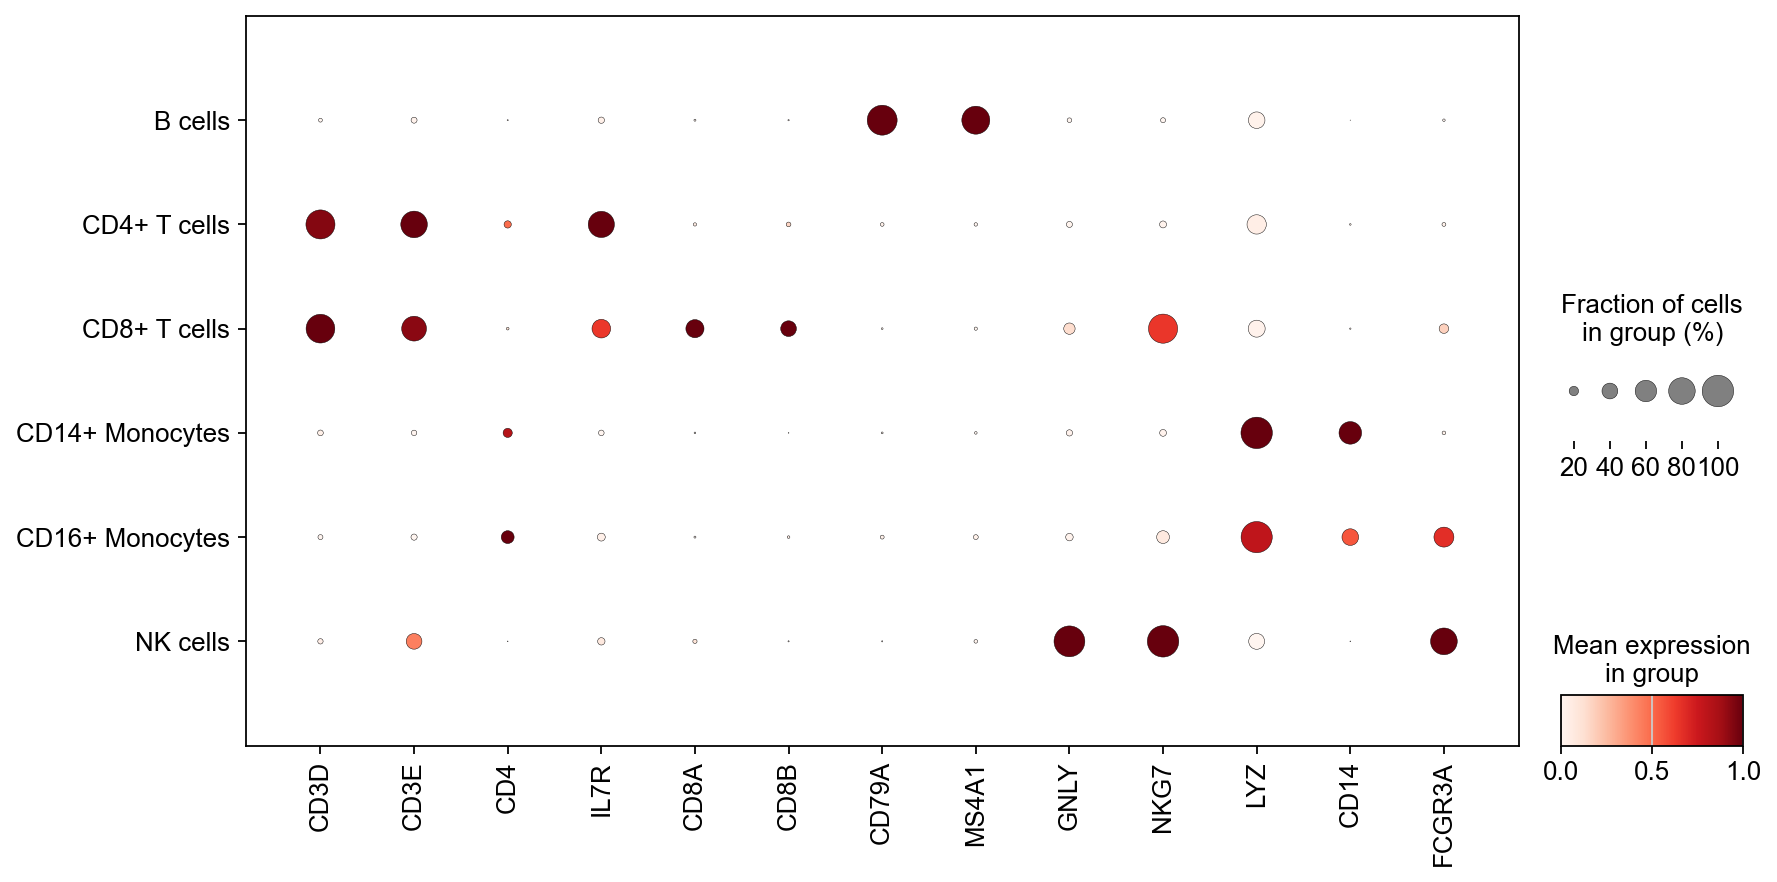

Validation dotplot created
Check that markers match expected cell types!


In [17]:
# Dotplot for validation
if len(available_markers) > 0:
    sc.pl.dotplot(
        adata_clean,
        var_names=available_markers,
        groupby='cell_type_merged',
        dendrogram=False,
        show=False,
        figsize=(12, 6),
        standard_scale='var'
    )
    plt.savefig(f'{results_dir}06_validation_dotplot.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Validation dotplot created")
    print("Check that markers match expected cell types!")

## 8. Matrix Plot of Key Markers

Compact view of marker expression across cell types.

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_cell_type_merged']`


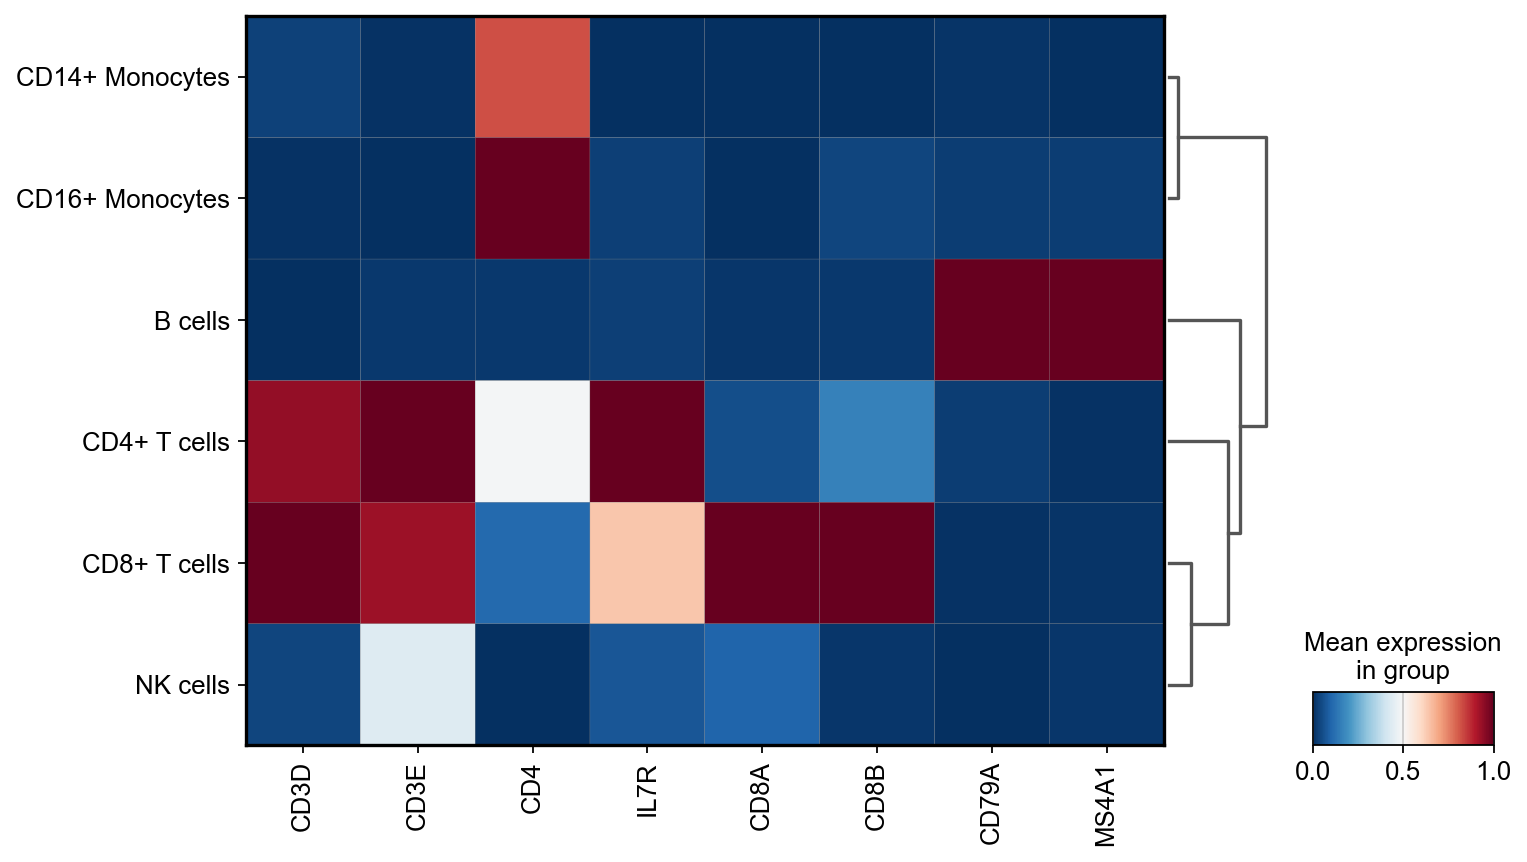

📊 Marker matrix plot created


In [18]:
# Matrix plot
if len(available_markers) >= 6:
    sc.pl.matrixplot(
        adata_clean,
        var_names=available_markers[:8],
        groupby='cell_type_merged',
        dendrogram=True,
        show=False,
        figsize=(10, 6),
        cmap='RdBu_r',
        standard_scale='var'
    )
    plt.savefig(f'{results_dir}06_marker_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("📊 Marker matrix plot created")

## 9. Export Annotations

Save cell type annotations for downstream analysis and reporting.

In [19]:
# Export cell metadata with annotations
cell_metadata = adata_clean.obs[['leiden', 'cell_type', 'cell_type_merged', 
                                   'n_genes_by_counts', 'total_counts', 'pct_counts_mt']]

cell_metadata.to_csv(f'{results_dir}06_cell_annotations.csv')

print("✅ Cell annotations exported!")
print(f"File: {results_dir}06_cell_annotations.csv")
print(f"Rows: {len(cell_metadata)}")

✅ Cell annotations exported!
File: ../results/06_cell_annotations.csv
Rows: 2134


## 10. Save Final Annotated Data

Save the cleaned and annotated dataset for downstream analysis.

In [21]:
# Save annotated data
adata_clean.write(f'{data_dir}pbmc3k_annotated.h5ad')

print("Final annotated data saved!")
print(f"File: {data_dir}pbmc3k_annotated.h5ad")
print(f"\nFinal state:")
print(f"  - Cells: {adata_clean.n_obs}")
print(f"  - Genes: {adata_clean.n_vars}")
print(f"  - Cell types: {adata_clean.obs['cell_type_merged'].nunique()}")
print(f"\nCell types: {', '.join(adata_clean.obs['cell_type_merged'].unique())}")

Final annotated data saved!
File: ../data/pbmc3k_annotated.h5ad

Final state:
  - Cells: 2134
  - Genes: 13671
  - Cell types: 6

Cell types: CD8+ T cells, B cells, CD4+ T cells, CD16+ Monocytes, NK cells, CD14+ Monocytes


## Summary

### What we accomplished:

1. **Loaded data** with marker gene results
2. **Manually annotated** 10 clusters with cell type labels
3. **Removed artifacts**: Platelets (cluster 9) and stressed cells (cluster 1)
4. **Merged similar clusters**: CD8+ T cells and CD16+ Monocytes
5. **Visualized** annotated UMAP
6. **Analyzed** cell type proportions
7. **Validated** annotations with known markers
8. **Exported** annotations to CSV
9. **Saved** final annotated dataset

---

### Final Cell Type Composition

**Identified cell types** (after cleanup):
- **CD4+ T cells**: Naive/memory T helper cells
- **CD8+ T cells**: Cytotoxic T lymphocytes (merged clusters 5 & 7)
- **B cells**: Antibody-producing lymphocytes
- **NK cells**: Natural killer cells
- **CD14+ Monocytes**: Classical monocytes
- **CD16+ Monocytes**: Non-classical monocytes (merged clusters 4 & 8)

**Total**: ~6 major cell types 

---

### Quality Checks

✅ **Marker validation**: Known markers expressed in correct cell types  
✅ **Proportions**: Match expected PBMC composition  
✅ **Spatial coherence**: Cell types form distinct clusters on UMAP  
✅ **Artifacts removed**: Platelets and stressed cells excluded  

---

### Biological Interpretation

**PBMC composition** is consistent with healthy peripheral blood:
- **T cells** (CD4+ and CD8+): ~50-60% → Adaptive immunity
- **B cells**: ~10-15% → Antibody production
- **Monocytes**: ~15-20% → Innate immunity, phagocytosis
- **NK cells**: ~5-10% → Innate cytotoxicity

**Our results match expected biology!** 

---

### 🚀 Next Steps: Notebook 07 - Biological Insights

In the next notebook, we will:
1. **Compare cell types** (differential expression between types)
2. **Pathway enrichment** analysis
3. **Gene set enrichment** analysis (GSEA)
4. **Biological interpretation** of cell type functions
5. **Visualize** key biological processes

---

**Congratulations! You've successfully annotated all cell types in your PBMC sample!**

**Your data is now ready for biological interpretation and downstream analysis!** 